### Import Libs

In [2]:

import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as Sns

import re
from gensim import corpora 
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from pymystem3 import Mystem
from sklearn.feature_extraction.text import TfidfVectorizer

import umap
import scipy.cluster.hierarchy as shc

from annoy import AnnoyIndex

2022-09-19 14:05:21.819206: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-09-19 14:05:21.819225: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


### Extract texts from files

In [3]:
df = pd.read_csv('dataset/filtere_dice_jobs_dataset.csv')
#df = df.iloc[:1000,:]
df['full_desc'] = df.jobtitle + df.jobdescription
df.shape

(1563, 13)

### Pre-processing and tokenization

In [4]:
def remove_number(documents):
    return [''.join([i for i in doc if not  i.isdigit()]) for doc in documents]

def remove_strang_char(documents):
    return [ re.sub(r'[^a-zA-Z0-9\#_+-]',r' ',doc) for doc in documents ]

def make_tokenize(documents):
    return [doc.lower().split() for doc in documents]

def get_stopset(documents)->set:
    standart_stopwords = stopwords.words('english')
    unigrams = [word for doc in documents for word in doc if len(word)==1]
    return set(unigrams+standart_stopwords)

def remove_stopwords(documents):
    stopset = get_stopset(documents)
    return [[word for word in doc if word not in stopset] for doc in documents]

def lemmetization(documents):
    lemm = Mystem()
    return [[''.join(lemm.lemmatize(word)).replace('\n','') for word in doc] for doc in documents]
    

In [5]:

docs = df.full_desc.fillna(' ').tolist()
docs = remove_strang_char(docs)

docs = remove_number(docs)

docs = make_tokenize(docs)
docs = lemmetization(docs)

docs = remove_stopwords(docs)

In [6]:
corpus = [''.join(doc) for doc in docs]

def dummy_fun(doc):
    return(doc)

vectorizer = TfidfVectorizer(ngram_range=(1,3),tokenizer=dummy_fun,token_pattern=None,preprocessor=dummy_fun)

x = vectorizer.fit_transform(docs)

In [8]:
from sklearn.metrics import silhouette_score

def get_umap(data,c=None,n_neighbors= 50, min_dist=0.2,n_components=2,metric='cosine',title=''):
    fit = umap.UMAP(n_neighbors=n_neighbors,min_dist=min_dist,n_components=n_components,metric=metric)
    u = fit.fit_transform(data)
    #print("Score of the cluster",silhouette_score(data, fit.labels, metric='euclidean'))
    
    return u
# from sklearn.decomposition import PCA
# pca = PCA(n_components = 10)
data = x.toarray()
umap = get_umap(data)


# p = pca.fit_transform(data)



KeyboardInterrupt: 

In [22]:
df['umap_0'] = umap[:,0]
df['umap_1'] = umap[:,1]

<Figure size 720x504 with 0 Axes>

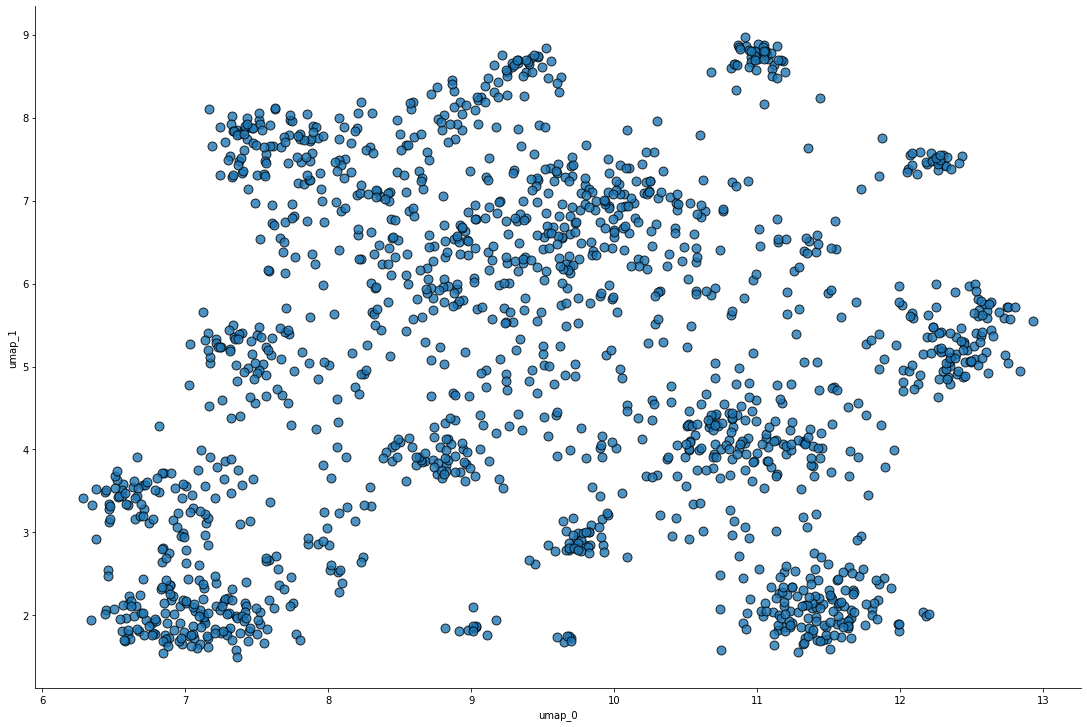

In [23]:
plt.figure(figsize=(10,7))
Sns.lmplot(x="umap_0",y="umap_1",data=df,fit_reg=False,legend=True,height=10,aspect=1.5,palette="gist_ncar",scatter_kws={'edgecolor':'k','s':80})

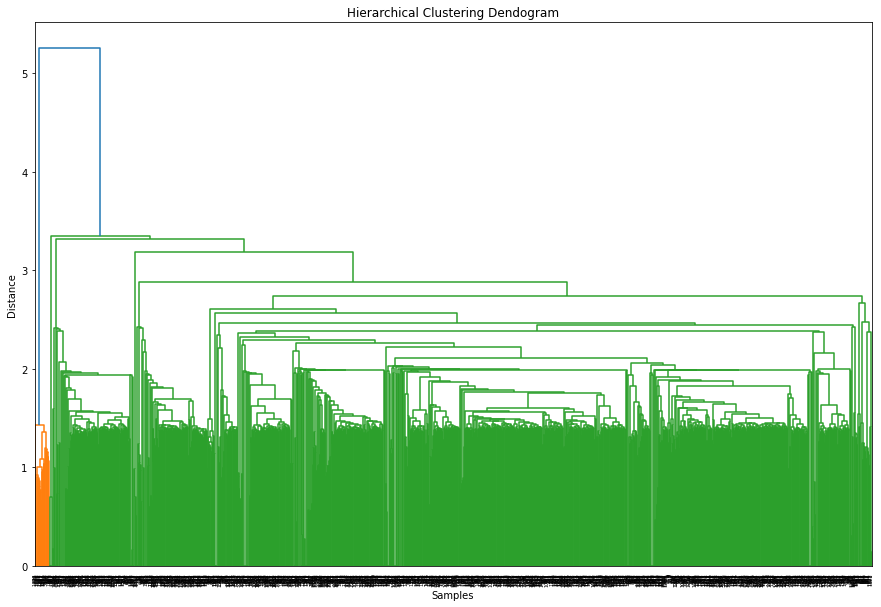

In [24]:
Z = shc.linkage(data,method='ward')

plt.figure(figsize=(15,10))
plt.title('Hierarchical Clustering Dendogram')
plt.xlabel('Samples')
plt.ylabel('Distance')
dend = shc.dendrogram(Z)

<Figure size 720x504 with 0 Axes>

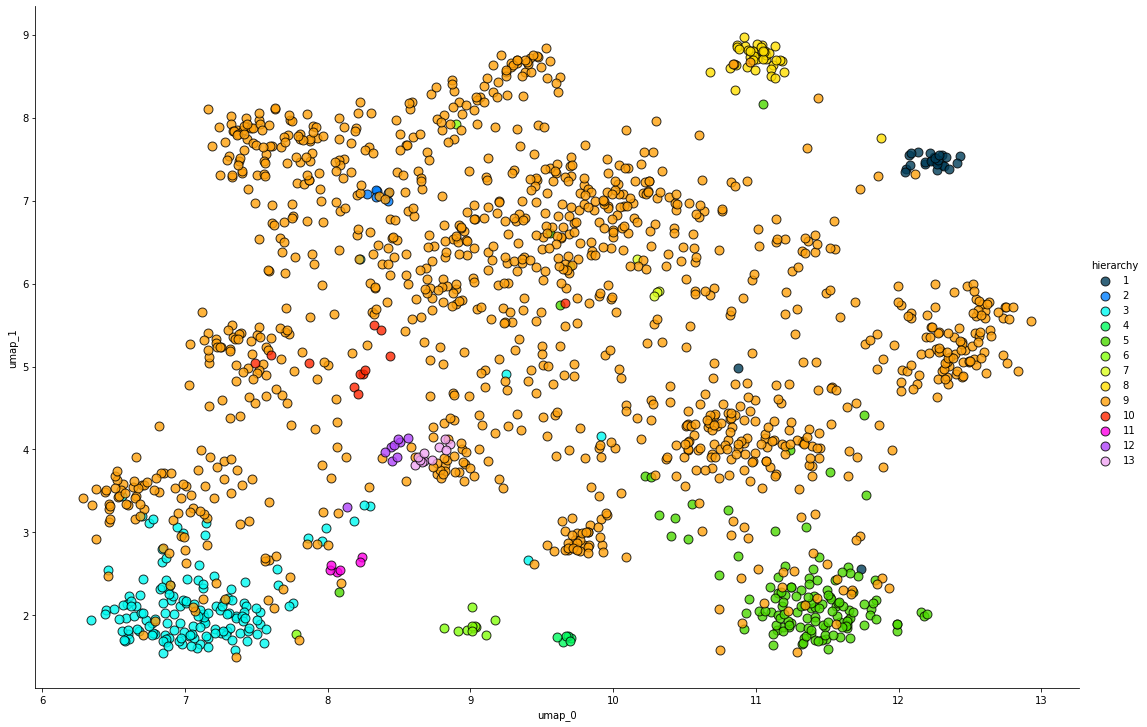

In [25]:
from scipy.cluster.hierarchy import fcluster

k = 13 
temp = fcluster(Z,k,criterion='maxclust')

df['hierarchy'] = temp

df_tf = pd.DataFrame(data,columns=vectorizer.get_feature_names())
df_tf['hierarchy'] = temp

plt.figure(figsize=(10,7))

Sns.lmplot(x="umap_0",y="umap_1",data=df,fit_reg=False,hue='hierarchy',legend=True,height=10,aspect=1.5,palette="gist_ncar",scatter_kws={'edgecolor':'k','s':80})